In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from collections import Counter
import random
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
import requests
# Step 1: Preprocess Text Data
tiny_shakes_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
# Fetch the content from the URL
response = requests.get(tiny_shakes_url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Read the content as text
    corpus = response.text
sentences = corpus.split('\n')
# Remove empty strings from the list
corpus = [sentence for sentence in sentences if sentence.strip()]

In [36]:
corpus[:10]

['First Citizen:',
 'Before we proceed any further, hear me speak.',
 'All:',
 'Speak, speak.',
 'First Citizen:',
 'You are all resolved rather to die than to famish?',
 'All:',
 'Resolved. resolved.',
 'First Citizen:',
 'First, you know Caius Marcius is chief enemy to the people.']

In [43]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import string
# Download NLTK punkt tokenizer if not already downloaded
nltk.download('punkt')

tokenized_sentences = []

# Tokenize sentences and update word counts
word_counts = Counter()
for sentence in sentences:
    tokens = word_tokenize(sentence)  # Tokenize sentence using NLTK's word tokenizer
    # Remove punctuations from tokens
    tokens = [word for word in tokens if word not in string.punctuation]
    if len(tokens) > 0:
      tokenized_sentences.append(tokens)  # Append tokenized sentence to the list
    word_counts.update(tokens)

# Extract vocabulary from word counts
vocab = [word for word, _ in word_counts.most_common()]

# Create word-to-index mapping
word_to_index = {word: idx for idx, word in enumerate(vocab)}

# Create index-to-word mapping
index_to_word = {idx: word for word, idx in word_to_index.items()}

# Determine vocabulary size
vocab_size = len(vocab)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
corpus = tokenized_sentences

In [45]:
corpus[:10]

[['First', 'Citizen'],
 ['Before', 'we', 'proceed', 'any', 'further', 'hear', 'me', 'speak'],
 ['All'],
 ['Speak', 'speak'],
 ['First', 'Citizen'],
 ['You',
  'are',
  'all',
  'resolved',
  'rather',
  'to',
  'die',
  'than',
  'to',
  'famish'],
 ['All'],
 ['Resolved', 'resolved'],
 ['First', 'Citizen'],
 ['First',
  'you',
  'know',
  'Caius',
  'Marcius',
  'is',
  'chief',
  'enemy',
  'to',
  'the',
  'people']]

In [50]:
class SkipgramDataset(Dataset):
    def __init__(self, corpus, word_to_index, window_size=2, num_negative_samples=5):
        self.corpus = corpus
        self.window_size = window_size
        self.num_negative_samples = num_negative_samples
        self.word_to_index = word_to_index
        self.data = self.generate_skipgrams()

    def generate_skipgrams(self):
        data = []
        for sentence in self.corpus:
            for i, target_word in enumerate(sentence):
                context = sentence[max(0, i - self.window_size):i] + sentence[i + 1:i + self.window_size + 1]
                for context_word in context:
                    data.append((self.word_to_index[target_word], self.word_to_index[context_word]))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        target_word, context_word = self.data[idx]
        negative_samples = self.generate_negative_samples(target_word)
        return target_word, context_word, torch.tensor(negative_samples)

    def generate_negative_samples(self, target_word):
      vocab_size = len(self.word_to_index)
      negative_samples = []
      while len(negative_samples) < self.num_negative_samples:
          sample = np.random.randint(0, vocab_size)
          if sample != target_word and sample not in negative_samples:
              negative_samples.append(sample)
      return negative_samples

In [51]:
# Step 3: Define Skipgram Model
class Skipgram(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(Skipgram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, target_word):
        embeds = self.embeddings(target_word)
        output = self.linear(embeds)
        return output

In [47]:
# Create dataset and dataloader
dataset = SkipgramDataset(corpus, word_to_index, window_size=4, num_negative_samples=5)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

# Iterate through the dataset and print samples
for i, sample in enumerate(dataset):
    if i >= 20:  # Print only the first 10 samples for demonstration
        break
    print(f"Sample {i+1}: Target Word Index - {sample[0]}, Context Word Index - {sample[1]}")

Sample 1: Target Word Index - 123, Context Word Index - 302
Sample 2: Target Word Index - 302, Context Word Index - 123
Sample 3: Target Word Index - 821, Context Word Index - 39
Sample 4: Target Word Index - 821, Context Word Index - 1560
Sample 5: Target Word Index - 821, Context Word Index - 161
Sample 6: Target Word Index - 821, Context Word Index - 770
Sample 7: Target Word Index - 39, Context Word Index - 821
Sample 8: Target Word Index - 39, Context Word Index - 1560
Sample 9: Target Word Index - 39, Context Word Index - 161
Sample 10: Target Word Index - 39, Context Word Index - 770
Sample 11: Target Word Index - 39, Context Word Index - 145
Sample 12: Target Word Index - 1560, Context Word Index - 821
Sample 13: Target Word Index - 1560, Context Word Index - 39
Sample 14: Target Word Index - 1560, Context Word Index - 161
Sample 15: Target Word Index - 1560, Context Word Index - 770
Sample 16: Target Word Index - 1560, Context Word Index - 145
Sample 17: Target Word Index - 15

In [54]:
# Hyperparameters
window_size = 2
num_negative_samples = 5
embedding_dim = 100
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Initialize model and optimizer
model = Skipgram(vocab_size, embedding_dim)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create dataset and data loader
num_negative_samples = 5  # Set your desired number of negative samples
dataset = SkipgramDataset(corpus, word_to_index, window_size, num_negative_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for target_word, context_word, negative_samples in dataloader:
        optimizer.zero_grad()
        target_word, context_word, negative_samples = target_word.to(device), context_word.to(device), negative_samples.to(device)

        # Positive examples
        positive_scores = model(target_word)
        positive_loss = criterion(positive_scores, context_word)

        # Negative examples
        negative_scores = model(negative_samples)
        negative_loss = criterion(negative_scores, torch.zeros_like(negative_scores))


        # Total loss
        loss = positive_loss + negative_loss

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")

Epoch 1, Loss: 7.212985228111969
Epoch 2, Loss: 6.503054898660586
Epoch 3, Loss: 6.326450060796019
Epoch 4, Loss: 6.214675574147635
Epoch 5, Loss: 6.132941687229982
Epoch 6, Loss: 6.067514708078068
Epoch 7, Loss: 6.014531910372196
Epoch 8, Loss: 5.9683754872368215
Epoch 9, Loss: 5.928489197444386
Epoch 10, Loss: 5.892484488041036


In [ ]:
# Step 5: Extract Word Embeddings
word_embeddings = model.embeddings.weight.data.cpu().numpy()
# Visualize word embeddings
# Run t-SNE and visualize the embeddings
tsne = TSNE(n_components=2, perplexity=10, random_state=42)
embedding_tsne = tsne.fit_transform(word_embeddings)

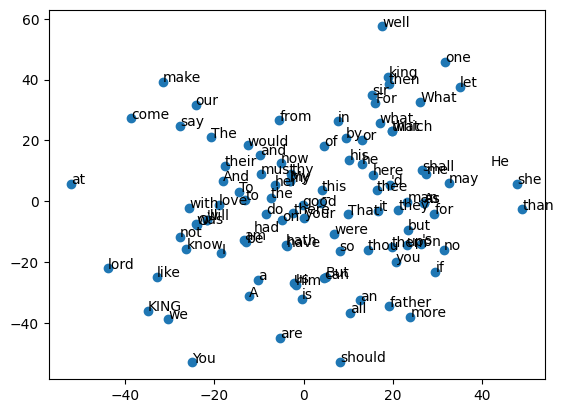

In [61]:
n = 100
# Visualize t-SNE plot
fig, ax = plt.subplots()
ax.scatter(embedding_tsne[:n, 0], embedding_tsne[:n, 1])

# Annotate points with words
for idx, word in index_to_word.items():
    ax.annotate(word, (embedding_tsne[idx, 0], embedding_tsne[idx, 1]))
    if idx > n:
      break
plt.show()